In [2]:
#dependencies
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
home_dir = os.path.dirname(os.getcwd())
gt_folder = os.path.join(home_dir,"data")
output_dir = os.path.join(home_dir,"output")
figure_dir = os.path.join(home_dir,"figures")

In [21]:
# helper functions
def collect_audio_by_subfolder(song_folder):
    audio_dict = {}
    for sub in os.listdir(song_folder):
        sub_path = os.path.join(song_folder, sub)
        if not os.path.isdir(sub_path):
            continue
        audio_files = [
            os.path.join(sub_path, f)
            for f in os.listdir(sub_path)
            if f.lower().endswith((".wav"))
        ]
        audio_dict[sub] = sorted(audio_files)
    return audio_dict

def extract_pitch_track(audio_path, fmin=75, fmax=400):
    # return pitch track (Hz) and time axis for a given audio file
    y, sr = librosa.load(audio_path, sr=None)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr, fmin=fmin, fmax=fmax)
    max_idx = np.argmax(magnitudes, axis=0)
    pitch_track = pitches[max_idx, range(magnitudes.shape[1])]
    times = librosa.times_like(pitch_track, sr=sr)
    return times, pitch_track

def pitch_corr(gt, est):
    mask = (gt > 0) & (est > 0)
    if mask.sum() < 10:
        return np.nan
    return np.corrcoef(np.log2(gt[mask]), np.log2(est[mask]))[0, 1]

def mfcc_cosine_similarity(mfcc_gt, mfcc_est):
    # mfcc frame specific cosine similarity
    n_frames = min(mfcc_gt.shape[1], mfcc_est.shape[1])
    cos_vals = []
    for i in range(n_frames):
        cos = cosine_similarity(mfcc_gt[:, i].reshape(1, -1),
                                mfcc_est[:, i].reshape(1, -1))[0, 0]
        cos_vals.append(cos)
    return np.mean(cos_vals), np.std(cos_vals)

In [6]:
# get files for tiki3
tiki3_gt_files = [os.path.join(gt_folder,'Tiki3_dev1/guitar.wav'),os.path.join(gt_folder,'Tiki3_dev1/vocals.wav')]
tiki3_bss_files = collect_audio_by_subfolder(os.path.join(output_dir,'Tiki3'))
# comp 0 inst, comp 1 vocal for all except NMF -> need to change order
tiki3_bss_files["NMF"] = tiki3_bss_files["NMF"][::-1]

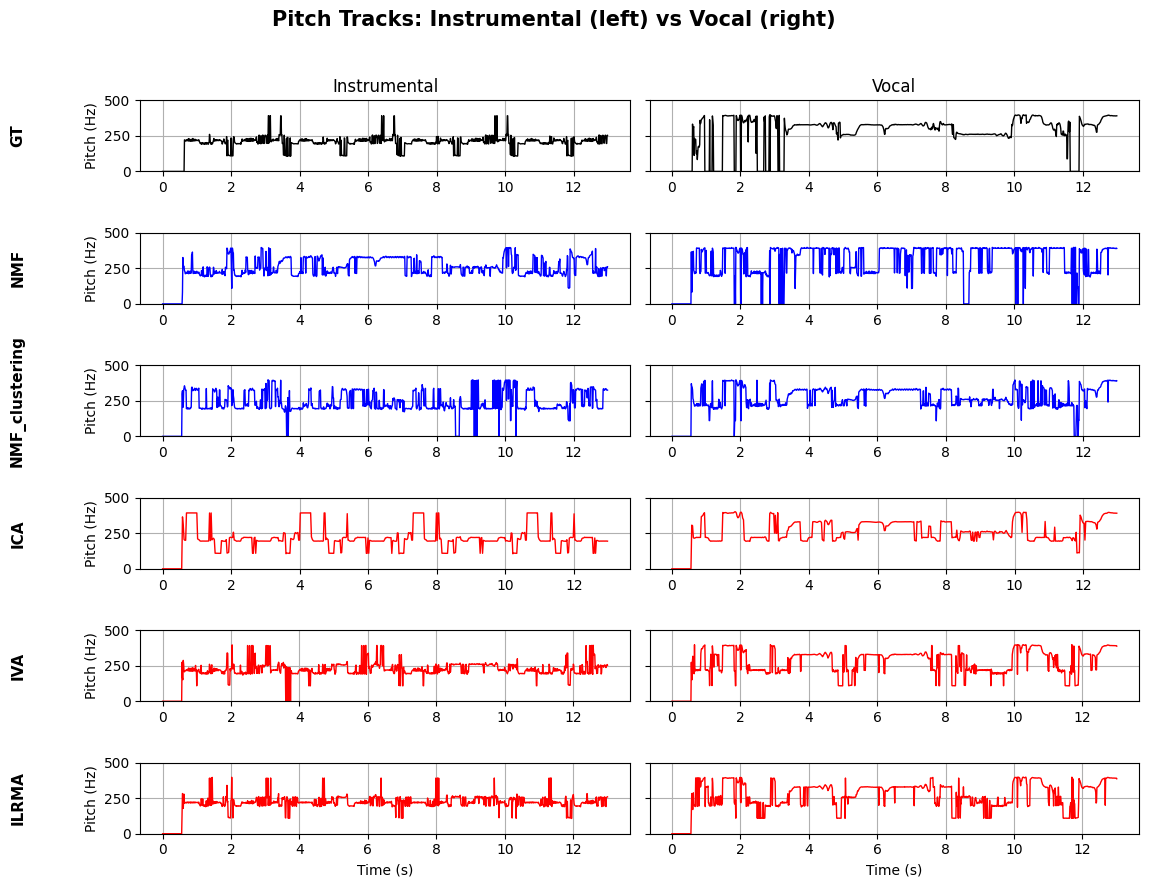

In [16]:
categories = ["Instrumental","Vocal"]
methods = ["GT", "NMF", "NMF_clustering", "ICA", "IVA", "ILRMA"]
all_files = {
    "GT": tiki3_gt_files,
    **tiki3_bss_files
}
pitch_tracks = {m: [] for m in methods}
colors = {
    "GT": "k",
    "NMF": "b",
    "NMF_clustering": "b",
    "ICA": "r",
    "IVA": "r",
    "ILRMA": "r"
}
# plot pitch comparisons:
fig, axes = plt.subplots(6, 2, figsize=(12, 9), sharex=False, sharey=True)
fig.subplots_adjust(hspace=0.4, wspace=0.25)
for row, method in enumerate(methods):
    paths = all_files[method]
    color = colors[method]

    for col, path in enumerate(paths):
        times, pitch_track = extract_pitch_track(path)
        pitch_track = np.nan_to_num(pitch_track)

        pitch_tracks[method].append(pitch_track)

        ax = axes[row, col]
        ax.plot(times, pitch_track, color=color, lw=1)
        ax.set_ylim(0, 500)
        ax.grid(True)

        if row == len(methods) - 1:
            ax.set_xlabel("Time (s)")
        if col == 0:
            ax.set_ylabel("Pitch (Hz)")
        if row == 0:
            ax.set_title(categories[col])

# row labels on the left
for ax, label in zip(axes[:, 0], methods):
    ax.annotate(label, xy=(-0.25, 0.5), xycoords="axes fraction",
                ha="center", va="center", rotation=90,
                fontsize=11, weight="bold")

fig.suptitle("Pitch Tracks: Instrumental (left) vs Vocal (right)", fontsize=15, weight='bold')
plt.tight_layout(rect=[0.05, 0, 1, 0.96])
plt.savefig(os.path.join(figure_dir,"tiki3_pitch_tracks_compare_to_GT.png"), dpi=300, bbox_inches="tight")
plt.show()

In [20]:
for col, source_type in enumerate(categories):
    gt = pitch_tracks["GT"][col]

    for method in methods[1:]:  # skip GROUND
        est = pitch_tracks[method][col]

        min_len = min(len(gt), len(est))
        gt_c = gt[:min_len]
        est_c = est[:min_len]

        sim = pitch_corr(gt_c, est_c)
        print(f"{source_type} | GT–{method}: {sim:.3f}")

Instrumental | GT–NMF: -0.030
Instrumental | GT–NMF_clustering: 0.061
Instrumental | GT–ICA: -0.303
Instrumental | GT–IVA: 0.165
Instrumental | GT–ILRMA: 0.243
Vocal | GT–NMF: 0.109
Vocal | GT–NMF_clustering: 0.418
Vocal | GT–ICA: -0.023
Vocal | GT–IVA: 0.572
Vocal | GT–ILRMA: 0.494


/tmp/ipykernel_1770834/2026713951.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0, 0.9, 0.96])


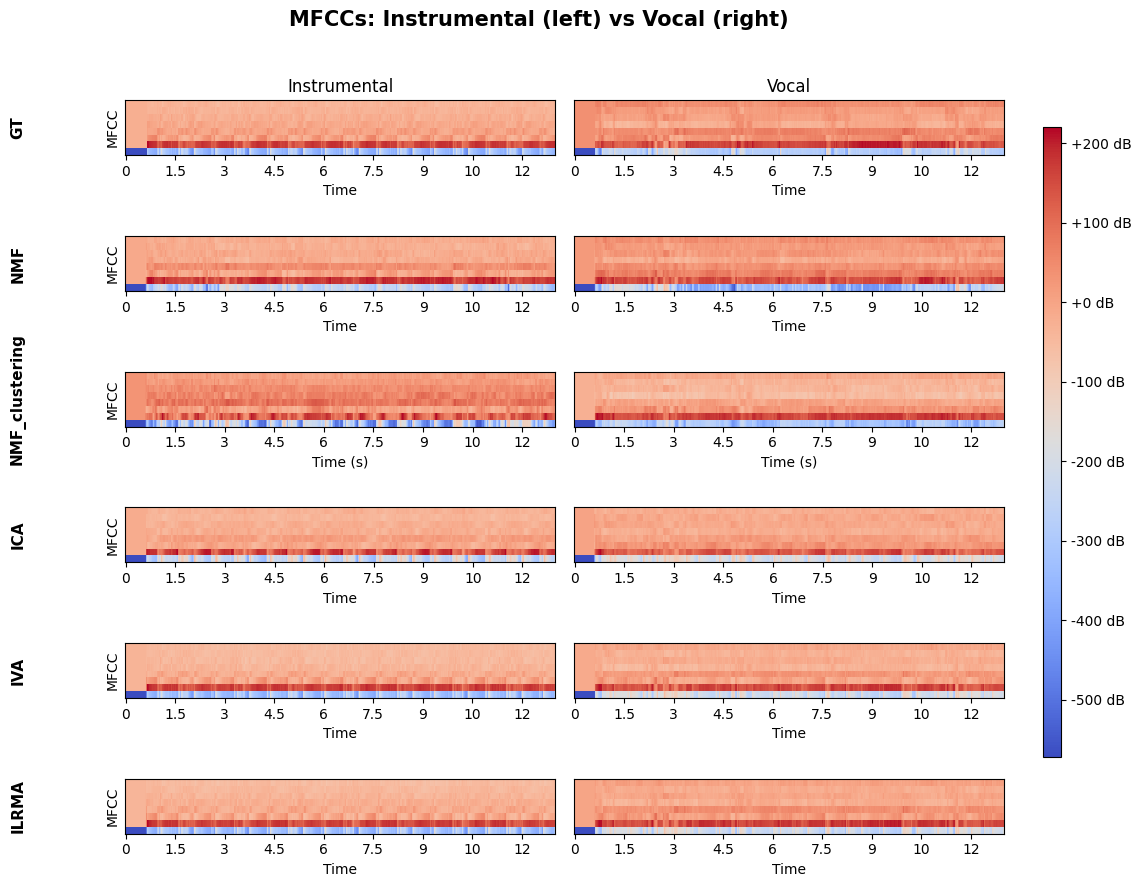

In [26]:
# plot MFCC comparison:
fig, axes = plt.subplots(6, 2, figsize=(12, 9), sharex=False, sharey=True)
fig.subplots_adjust(hspace=0.4, wspace=0.25)
MFCCS = {m: [] for m in methods}
for row, method in enumerate(methods):
    paths = all_files[method]
    color = colors[method]

    for col, path in enumerate(paths):
        y, sr = librosa.load(path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=8)
        MFCCS[method].append(mfccs)
        ax = axes[row, col]
        img = librosa.display.specshow(mfccs, x_axis="time", ax=ax, sr=sr)
        ax.set_title(categories[col] if row == 0 else "")
        if row == 2:
            ax.set_xlabel("Time (s)")
        if col == 0:
            ax.set_ylabel("MFCC")
        ax.grid(False)

# row labels on the left
for ax, label in zip(axes[:, 0], methods):
    ax.annotate(label, xy=(-0.25, 0.5), xycoords="axes fraction",
                ha="center", va="center", rotation=90,
                fontsize=11, weight="bold")

fig.suptitle("MFCCs: Instrumental (left) vs Vocal (right)", fontsize=15, weight='bold')
# color bar
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(img, cax=cbar_ax, format='%+2.0f dB')

plt.tight_layout(rect=[0.05, 0, 0.9, 0.96])
plt.savefig(os.path.join(figure_dir,"tiki3_MFCCs_compare_to_GT.png"), dpi=300, bbox_inches="tight")
plt.show()

In [27]:
for col, source_type in enumerate(categories):
    gt = MFCCS["GT"][col]

    for method in methods[1:]:  # skip GROUND
        est = MFCCS[method][col]
        cos_est,_ = mfcc_cosine_similarity(gt, est)
        print(f"{source_type} | GT–{method}: {cos_est:.3f}")

Instrumental | GT–NMF: 0.975
Instrumental | GT–NMF_clustering: 0.928
Instrumental | GT–ICA: 0.948
Instrumental | GT–IVA: 0.993
Instrumental | GT–ILRMA: 0.995
Vocal | GT–NMF: 0.960
Vocal | GT–NMF_clustering: 0.944
Vocal | GT–ICA: 0.901
Vocal | GT–IVA: 0.918
Vocal | GT–ILRMA: 0.938


In [30]:
# get files for die with a smile
gaga_gt_files = [os.path.join(gt_folder,'inst_trimmed.wav'),os.path.join(gt_folder,'vocal_trimmed.wav')]
gaga_bss_files = collect_audio_by_subfolder(os.path.join(output_dir,'die_with_a_smile'))

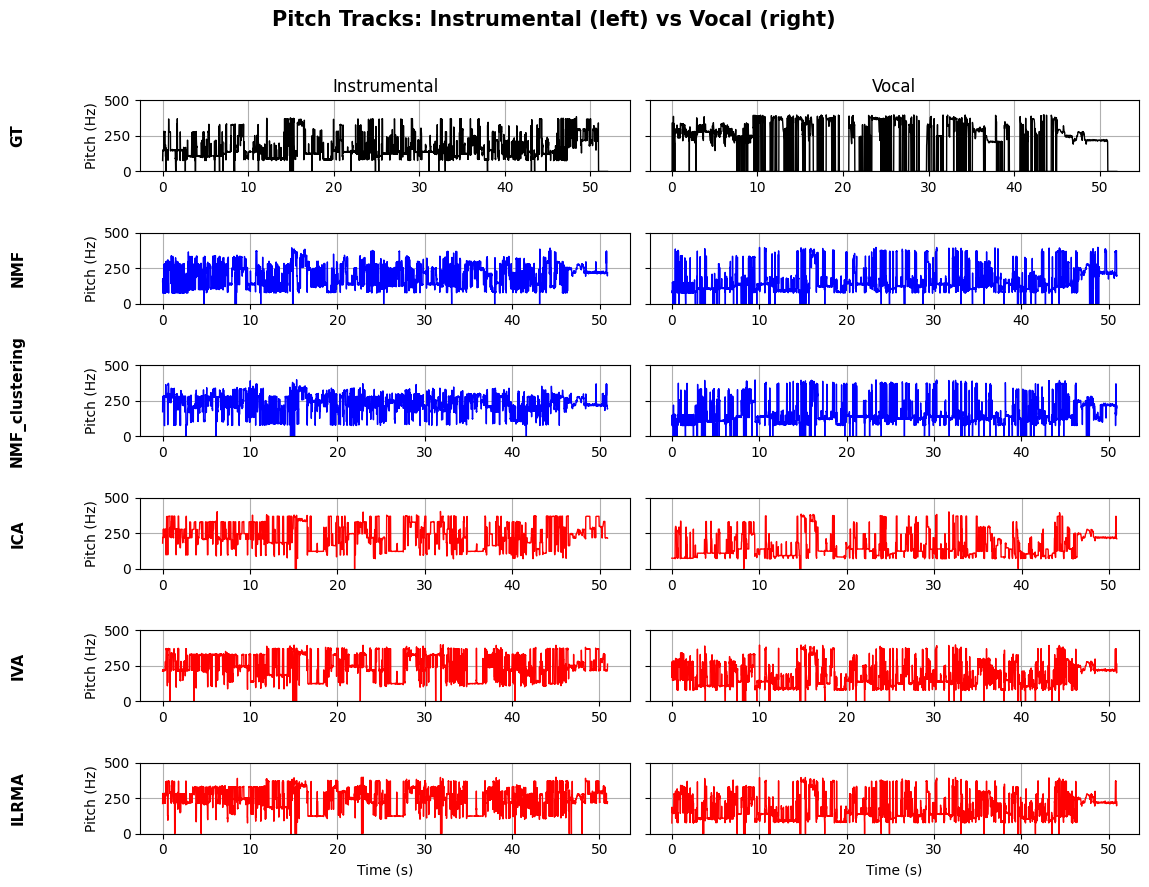

In [35]:
categories = ["Instrumental","Vocal"]
methods = ["GT", "NMF", "NMF_clustering", "ICA", "IVA", "ILRMA"]
all_files = {
    "GT": gaga_gt_files,
    **gaga_bss_files
}
pitch_tracks = {m: [] for m in methods}
colors = {
    "GT": "k",
    "NMF": "b",
    "NMF_clustering": "b",
    "ICA": "r",
    "IVA": "r",
    "ILRMA": "r"
}
# plot pitch comparisons:
fig, axes = plt.subplots(6, 2, figsize=(12, 9), sharex=False, sharey=True)
fig.subplots_adjust(hspace=0.4, wspace=0.25)
for row, method in enumerate(methods):
    paths = all_files[method]
    color = colors[method]

    for col, path in enumerate(paths):
        times, pitch_track = extract_pitch_track(path)
        pitch_track = np.nan_to_num(pitch_track)

        pitch_tracks[method].append(pitch_track)

        ax = axes[row, col]
        ax.plot(times, pitch_track, color=color, lw=1)
        ax.set_ylim(0, 500)
        ax.grid(True)

        if row == len(methods) - 1:
            ax.set_xlabel("Time (s)")
        if col == 0:
            ax.set_ylabel("Pitch (Hz)")
        if row == 0:
            ax.set_title(categories[col])

# row labels on the left
for ax, label in zip(axes[:, 0], methods):
    ax.annotate(label, xy=(-0.25, 0.5), xycoords="axes fraction",
                ha="center", va="center", rotation=90,
                fontsize=11, weight="bold")

fig.suptitle("Pitch Tracks: Instrumental (left) vs Vocal (right)", fontsize=15, weight='bold')
plt.tight_layout(rect=[0.05, 0, 1, 0.96])
plt.savefig(os.path.join(figure_dir,"gaga_pitch_tracks_compare_to_GT.png"), dpi=300, bbox_inches="tight")
plt.show()

In [32]:
for col, source_type in enumerate(categories):
    gt = pitch_tracks["GT"][col]

    for method in methods[1:]:  # skip GROUND
        est = pitch_tracks[method][col]

        min_len = min(len(gt), len(est))
        gt_c = gt[:min_len]
        est_c = est[:min_len]

        sim = pitch_corr(gt_c, est_c)
        print(f"{source_type} | GT–{method}: {sim:.3f}")

Instrumental | GT–NMF: 0.367
Instrumental | GT–NMF_clustering: 0.195
Instrumental | GT–ICA: 0.037
Instrumental | GT–IVA: 0.058
Instrumental | GT–ILRMA: 0.049
Vocal | GT–NMF: -0.035
Vocal | GT–NMF_clustering: -0.000
Vocal | GT–ICA: -0.010
Vocal | GT–IVA: -0.057
Vocal | GT–ILRMA: -0.074
